# To-Dos

In [ ]:
## Outlier Removal
## IF/ELSE LOGIC FOR QUERY DEPENDING ON IF IBV PROVIDER OR FUNNEL STEPS.
    ##### PULL ALL FUNNEL STEPS, BUT INCLUDE LIMITING OF FINAL DF IN THIS FUNCTION.
    ##### ENSURE COMMON NOMENCLATURE OF COLUMN NAMES

# Import Packages

In [26]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [28]:
check.packages(c('RPostgreSQL', 'RJDBC', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot', 'rJava'))

RPostgreSQL       RJDBC     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      rJava 
       TRUE

In [29]:
options(scipen = 999)

# Connect to Database

In [30]:
killDbConnections = function () {
  all_cons = dbListConnections(PostgreSQL())
  print(all_cons)
  for(con in all_cons)
    +  dbDisconnect(con)
  
#   print(paste(length(all_cons), " connections killed."))
}

In [31]:
createReportingConnectionObject = function() {
    
    killDbConnections()
    
    drv = dbDriver('PostgreSQL')

    reporting = dbConnect(
      drv,
      dbname = 'reporting',
      host = 'reporting.ckpglb17yttu.us-east-1.rds.amazonaws.com',
      port = 5432,
      user = Sys.getenv('REPORTING_USER'),
      password = Sys.getenv('REPORTING_PASS')
    )
}

In [32]:
# ## Create function to pull in string depending on the funnel step.

# getQueryString = function(funnelStep) {
        
#     queryString = ''

#     if(funnelStep == 'qualified') {
#         queryString = "count(distinct case when old_value = 'BUSINESS RULES PASSED' and new_value = 'BUREAU APPROVED' then c_ash.application end)"

#     } else if(funnelStep == 'bankverified') {
#         queryString = "count(distinct case when (c_ash.old_value = 'BANK VERIFICATION COMPLETED' and c_ash.new_value = 'NEW - SCORECARD GENERATED') or c_ash.new_value = 'BANK VERIFICATION COMPLETED' then c_ash.application end)"

#     } else if(funnelStep == 'passscorecardratecard') {
#         queryString = "count(distinct case when c_ash.old_value = 'NEW - PRICING GENERATED' and c_ash.new_value in ('CONTRACT SIGNED', 'WAITING ON STIPULATIONS') then c_ash.application end)"

#     } else if(funnelStep == 'contractsigned') {
#         queryString = "count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' then c_ash.application end)"

#     } else if(funnelStep == 'cs_decisioned') {
#         queryString = "count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' and (c_app.denialreason not in ('Withdraw','Time In Pending') or c_app.status = 'LOAN APPROVED') then c_ash.application end)"

#     } else if(funnelStep == 'funded') {
#         queryString = "count(distinct case when c_ash.new_value = 'LOAN APPROVED' then c_ash.application end)"

#     }
        
#     return(queryString)
# }

In [33]:
checkReportingConnection = function() {
    
    print(paste(length(dbListConnections(PostgreSQL())), " connections active."))
}

In [34]:
getQueryString = function(date.string, ibv.provider) {
    
    if (is.na(ibv.provider)) {
        
        query.string = paste(
            "
            with time_limit_gmt as 
            (
              select
                date_trunc('hour', min(createddate_)) as createddate_
              from
                (
                  select
                    max(createddate) as createddate_
                  from
                    cloudlending.application_status_history

                  union all

                  select
                    max(createddate) as createddate_
                  from
                    cloudlending.applications
                ) as latest_dates
            )
            select
              (c_ash.createddate at time zone 'America/Chicago')::date as dayofyear
              , extract(dow from c_ash.createddate at time zone 'America/Chicago') as dayofweek
              , extract(hour from c_ash.createddate at time zone 'America/Chicago') as hourofday

            --     , count(distinct case when new_value = 'NEW - ENTERED' then p_ap.loanid end) as newentered
            --     , count(distinct case when c_ash.old_value = 'NEW - ENTERED' and c_ash.new_value = 'BUSINESS RULES PASSED' then p_ap.loanid end) as bizrulespassed

              , count(distinct case when left(p_ap.denygrp,1) > '2' 
                                    then p_ap.loanid 
                                    end) as qualified

              , count(distinct case when (c_ash.old_value = 'BANK VERIFICATION COMPLETED' and c_ash.new_value = 'NEW - SCORECARD GENERATED') or c_ash.new_value = 'BANK VERIFICATION COMPLETED'
                                    then p_ap.loanid 
                                    end) as bankverified

              , count(distinct case when c_ash.old_value = 'NEW - PRICING GENERATED' and c_ash.new_value in ('CONTRACT SIGNED', 'WAITING ON STIPULATIONS') 
                                    then p_ap.loanid 
                                    end) as passscorecardratecard

              , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' 
                                    then p_ap.loanid 
                                    end) as contractsigned

              , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' and left(p_ap.denygrp,1) not in ('4','5','8') 
                                    then p_ap.loanid 
                                    end) as cs_decisioned

              , count(distinct case when left(p_ap.denygrp,1) = '9' 
                                    then p_ap.loanid 
                                    end) as funded

              , case  when (c_ash.createddate at time zone 'America/Chicago')::date = '", date.string, "'::date 
                      then 'test' 
                      else 'training' 
                      end as grouping
            from
              public.all_allapps as p_ap
              inner join
                cloudlending.applications as c_app
                on p_ap.loanid = c_app.name
              inner join
                cloudlending.application_status_history as c_ash
                on c_app.id = c_ash.application
              inner join
                time_limit_gmt
                on TRUE
            where
              c_app.createddate < createddate_
              and c_ash.createddate < createddate_
              and (c_ash.createddate at time zone 'America/Chicago')::date >= '", date.string, "'::date - '3 months'::interval
              and p_ap.refi = 'N'
            group by
              dayofyear
              , dayofweek
              , hourofday
              , grouping
            order by
              dayofyear asc
              , hourofday asc
            ",
            sep = ''
        )        
    } else {
        
        query.string = paste(
            "
            with time_limit_gmt as 
            (
              select
                date_trunc('hour', min(createddate_)) as createddate_
              from
                (
                  select
                    max(createddate) as createddate_
                  from
                    cloudlending.application_status_history

                  union all

                  select
                    max(createddate) as createddate_
                  from
                    cloudlending.microbilt_information
                ) as latest_dates
            )
            , qualified as
            (
              select
                application
                , min(createddate at time zone 'America/Chicago') as createddate_
              from
                cloudlending.application_status_history
                inner join
                  time_limit_gmt
                  on TRUE
              where
                createddate < createddate_
                and old_value = 'BUSINESS RULES PASSED'
                and new_value = 'BUREAU APPROVED'
              group by
                application
            )
            , qualified_counts as
            (
              select
                date_trunc('hour', createddate_) as q_time
                , count(*) as q
              from
                qualified
              group by
                q_time
            )
            , bankverified as
            (
              select
                c_ash.application
                , min(c_ash.createddate at time zone 'America/Chicago') as createddate_
              from
                cloudlending.application_status_history as c_ash
                inner join
                  time_limit_gmt
                  on TRUE
                inner join
                  (
                    select
                      application
                    from
                      (
                        select
                          *
                          , row_number() over (partition by application order by createddate desc) as rn
                        from
                          cloudlending.microbilt_information
                        inner join
                          time_limit_gmt
                          on TRUE
                      where
                        createddate < createddate_
                      ) as c_mb
                    where
                      rn = 1
                      and c_mb.ibv_source = '", ibv.provider, "'
                  ) as c_mb
                  on c_ash.application = c_mb.application
              where
                createddate < createddate_
                and c_ash.new_value = 'BANK VERIFICATION COMPLETED'
                or
                  (
                    c_ash.old_value = 'BANK VERIFICATION COMPLETED' 
                    and c_ash.new_value = 'NEW - SCORECARD GENERATED'
                  )
              group by
                c_ash.application
            )
            , bankverified_counts as
            (
              select
                date_trunc('hour', createddate_) as bv_time
                , count(*) as bv
              from
                bankverified
              group by
                bv_time
            )
            select
              q_time::date as dayofyear
              , extract(dow from q_time) as dayofweek
              , extract(hour from q_time) as hourofday
              , coalesce(q,0) as q
              , coalesce(bv,0) as bv
              , 'training' as grouping
            from
              qualified_counts as qc
              left join
                bankverified_counts as bvc
                on qc.q_time = bvc.bv_time
            where
              q_time::date >= '", date.string, "'::date - '3 months'::interval
              and q_time::date < '", date.string, "'::date

            union all


            select
              q_time::date as dayofyear
              , extract(dow from q_time) as dayofweek
              , extract(hour from q_time) as hourofday
              , coalesce(q,0) as q
              , coalesce(bv,0) as bv
              , 'test' as grouping
            from
              qualified_counts as qc
              left join
                bankverified_counts as bvc
                on qc.q_time = bvc.bv_time
            where
              q_time::date = '", date.string, "'::date

            order by
              dayofyear asc
              , hourofday asc
            ",
            sep = ''
            )
    }
    
    return(query.string)
}

In [35]:
getDf = function(date.string, ibv.provider = NA, numerator.string = NA, denominator.string = NA) {
    
    df = dbGetQuery(
        createReportingConnectionObject(),
        getQueryString(
            date.string = date.string,
            ibv.provider = ibv.provider
        )
    )
    
    if (is.na(ibv.provider)) {
        
        df.subset = df[ , which(colnames(df) %in% c('dayofyear', 'dayofweek', 'hourofday', denominator.string, numerator.string, 'grouping'))]
        
    } else {
        
        df.subset = df
        
    }   
    
    colnames(df.subset) = c('dayofyear', 'dayofweek', 'hourofday', 'denominator', 'numerator', 'grouping')
    
    return(df.subset)
}

In [ ]:
# getDf = function(date.string, ibv.provider = NA) {
    
#     if (is.na(ibv.provider)) {
        
#         df = dbGetQuery(
#             createReportingConnectionObject(),
#             paste(
#                 "
#                 with time_limit_gmt as 
#                 (
#                   select
#                     date_trunc('hour', min(createddate_)) as createddate_
#                   from
#                     (
#                       select
#                         max(createddate) as createddate_
#                       from
#                         cloudlending.application_status_history

#                       union all

#                       select
#                         max(createddate) as createddate_
#                       from
#                         cloudlending.applications
#                     ) as latest_dates
#                 )
#                 select
#                   (c_ash.createddate at time zone 'America/Chicago')::date as dayofyear
#                   , extract(dow from c_ash.createddate at time zone 'America/Chicago') as dayofweek
#                   , extract(hour from c_ash.createddate at time zone 'America/Chicago') as hourofday

#                 --     , count(distinct case when new_value = 'NEW - ENTERED' then p_ap.loanid end) as newentered
#                 --     , count(distinct case when c_ash.old_value = 'NEW - ENTERED' and c_ash.new_value = 'BUSINESS RULES PASSED' then p_ap.loanid end) as bizrulespassed

#                   , count(distinct case when left(p_ap.denygrp,1) > '2' 
#                                         then p_ap.loanid 
#                                         end) as qualified

#                   , count(distinct case when (c_ash.old_value = 'BANK VERIFICATION COMPLETED' and c_ash.new_value = 'NEW - SCORECARD GENERATED') or c_ash.new_value = 'BANK VERIFICATION COMPLETED'
#                                         then p_ap.loanid 
#                                         end) as bankverified

#                   , count(distinct case when c_ash.old_value = 'NEW - PRICING GENERATED' and c_ash.new_value in ('CONTRACT SIGNED', 'WAITING ON STIPULATIONS') 
#                                         then p_ap.loanid 
#                                         end) as passscorecardratecard

#                   , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' 
#                                         then p_ap.loanid 
#                                         end) as contractsigned

#                   , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' and left(p_ap.denygrp,1) not in ('4','5','8') 
#                                         then p_ap.loanid 
#                                         end) as cs_decisioned

#                   , count(distinct case when left(p_ap.denygrp,1) = '9' 
#                                         then p_ap.loanid 
#                                         end) as funded

#                   , case  when (c_ash.createddate at time zone 'America/Chicago')::date = '", date.string, "'::date 
#                           then 'test' 
#                           else 'training' 
#                           end as grouping
#                 from
#                   public.all_allapps as p_ap
#                   inner join
#                     cloudlending.applications as c_app
#                     on p_ap.loanid = c_app.name
#                   inner join
#                     cloudlending.application_status_history as c_ash
#                     on c_app.id = c_ash.application
#                   inner join
#                     time_limit_gmt
#                     on TRUE
#                 where
#                   c_app.createddate < createddate_
#                   and c_ash.createddate < createddate_
#                   and (c_ash.createddate at time zone 'America/Chicago')::date >= '", date.string, "'::date - '3 months'::interval
#                   and p_ap.refi = 'N'
#                 group by
#                   dayofyear
#                   , dayofweek
#                   , hourofday
#                   , grouping
#                 order by
#                   dayofyear asc
#                   , hourofday asc
#                 ",
#                 sep = ''
#             )
#         )
        
#     } else {
        
#         df = dbGetQuery(
#             createReportingConnectionObject(),
#             paste(
#                 "
#                 with time_limit_gmt as 
#                 (
#                   select
#                     date_trunc('hour', min(createddate_)) as createddate_
#                   from
#                     (
#                       select
#                         max(createddate) as createddate_
#                       from
#                         cloudlending.application_status_history

#                       union all

#                       select
#                         max(createddate) as createddate_
#                       from
#                         cloudlending.microbilt_information
#                     ) as latest_dates
#                 )
#                 , qualified as
#                 (
#                   select
#                     application
#                     , min(createddate at time zone 'America/Chicago') as createddate_
#                   from
#                     cloudlending.application_status_history
#                     inner join
#                       time_limit_gmt
#                       on TRUE
#                   where
#                     createddate < createddate_
#                     and old_value = 'BUSINESS RULES PASSED'
#                     and new_value = 'BUREAU APPROVED'
#                   group by
#                     application
#                 )
#                 , qualified_counts as
#                 (
#                   select
#                     date_trunc('hour', createddate_) as q_time
#                     , count(*) as q
#                   from
#                     qualified
#                   group by
#                     q_time
#                 )
#                 , bankverified as
#                 (
#                   select
#                     c_ash.application
#                     , min(c_ash.createddate at time zone 'America/Chicago') as createddate_
#                   from
#                     cloudlending.application_status_history as c_ash
#                     inner join
#                       time_limit_gmt
#                       on TRUE
#                     inner join
#                       (
#                         select
#                           application
#                         from
#                           (
#                             select
#                               *
#                               , row_number() over (partition by application order by createddate desc) as rn
#                             from
#                               cloudlending.microbilt_information
#                             inner join
#                               time_limit_gmt
#                               on TRUE
#                           where
#                             createddate < createddate_
#                           ) as c_mb
#                         where
#                           rn = 1
#                           and c_mb.ibv_source = '", ibv.provider, "'
#                       ) as c_mb
#                       on c_ash.application = c_mb.application
#                   where
#                     createddate < createddate_
#                     and c_ash.new_value = 'BANK VERIFICATION COMPLETED'
#                     or
#                       (
#                         c_ash.old_value = 'BANK VERIFICATION COMPLETED' 
#                         and c_ash.new_value = 'NEW - SCORECARD GENERATED'
#                       )
#                   group by
#                     c_ash.application
#                 )
#                 , bankverified_counts as
#                 (
#                   select
#                     date_trunc('hour', createddate_) as bv_time
#                     , count(*) as bv
#                   from
#                     bankverified
#                   group by
#                     bv_time
#                 )
#                 select
#                   q_time::date as dayofyear
#                   , extract(dow from q_time) as dayofweek
#                   , extract(hour from q_time) as hourofday
#                   , coalesce(q,0) as q
#                   , coalesce(bv,0) as bv
#                   , 'training' as grouping
#                 from
#                   qualified_counts as qc
#                   left join
#                     bankverified_counts as bvc
#                     on qc.q_time = bvc.bv_time
#                 where
#                   q_time::date >= '", date.string, "'::date - '3 months'::interval
#                   and q_time::date < '", date.string, "'::date

#                 union all


#                 select
#                   q_time::date as dayofyear
#                   , extract(dow from q_time) as dayofweek
#                   , extract(hour from q_time) as hourofday
#                   , coalesce(q,0) as q
#                   , coalesce(bv,0) as bv
#                   , 'test' as grouping
#                 from
#                   qualified_counts as qc
#                   left join
#                     bankverified_counts as bvc
#                     on qc.q_time = bvc.bv_time
#                 where
#                   q_time::date = '", date.string, "'::date

#                 order by
#                   dayofyear asc
#                   , hourofday asc
#                 ",
#                 sep = ''
#             )
#         )
#     }
    
#     return(df)
# }

In [ ]:
# getDf = function(date.string) {
    
#     df = dbGetQuery(
#         createReportingConnectionObject(),
#         paste(
#             "
#             with time_limit_gmt as 
#             (
#               select
#                 date_trunc('hour', min(createddate_)) as createddate_
#               from
#                 (
#                   select
#                     max(createddate) as createddate_
#                   from
#                     cloudlending.application_status_history

#                   union all

#                   select
#                     max(createddate) as createddate_
#                   from
#                     cloudlending.applications
#                 ) as latest_dates
#             )
#             select
#               (c_ash.createddate at time zone 'America/Chicago')::date as dayofyear
#               , extract(dow from c_ash.createddate at time zone 'America/Chicago') as dayofweek
#               , extract(hour from c_ash.createddate at time zone 'America/Chicago') as hourofday

#             --     , count(distinct case when new_value = 'NEW - ENTERED' then p_ap.loanid end) as newentered
#             --     , count(distinct case when c_ash.old_value = 'NEW - ENTERED' and c_ash.new_value = 'BUSINESS RULES PASSED' then p_ap.loanid end) as bizrulespassed

#               , count(distinct case when left(p_ap.denygrp,1) > '2' 
#                                     then p_ap.loanid 
#                                     end) as qualified

#               , count(distinct case when (c_ash.old_value = 'BANK VERIFICATION COMPLETED' and c_ash.new_value = 'NEW - SCORECARD GENERATED') or c_ash.new_value = 'BANK VERIFICATION COMPLETED'
#                                     then p_ap.loanid 
#                                     end) as bankverified

#               , count(distinct case when c_ash.old_value = 'NEW - PRICING GENERATED' and c_ash.new_value in ('CONTRACT SIGNED', 'WAITING ON STIPULATIONS') 
#                                     then p_ap.loanid 
#                                     end) as passscorecardratecard

#               , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' 
#                                     then p_ap.loanid 
#                                     end) as contractsigned

#               , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' and left(p_ap.denygrp,1) not in ('4','5','8') 
#                                     then p_ap.loanid 
#                                     end) as cs_decisioned

#               , count(distinct case when left(p_ap.denygrp,1) = '9' 
#                                     then p_ap.loanid 
#                                     end) as funded

#               , case  when (c_ash.createddate at time zone 'America/Chicago')::date = '", date.string, "'::date 
#                       then 'test' 
#                       else 'training' 
#                       end as grouping
#             from
#               public.all_allapps as p_ap
#               inner join
#                 cloudlending.applications as c_app
#                 on p_ap.loanid = c_app.name
#               inner join
#                 cloudlending.application_status_history as c_ash
#                 on c_app.id = c_ash.application
#               inner join
#                 time_limit_gmt
#                 on TRUE
#             where
#               c_app.createddate < createddate_
#               and c_ash.createddate < createddate_
#               and (c_ash.createddate at time zone 'America/Chicago')::date >= '", date.string, "'::date - '3 months'::interval
#               and p_ap.refi = 'N'
#             group by
#               dayofyear
#               , dayofweek
#               , hourofday
#               , grouping
#             order by
#               dayofyear asc
#               , hourofday asc
#             ",
#             sep = ''
#         )
#     )
    
#     return(df)
# }







# Import Data

In [ ]:
# ## 2018-12-18 -- Wells Fargo DL Outage
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-27_0049.csv')

# ## 2018-12-20 -- Everything OK
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0857.csv')

# ## 2010-01-01 -- Complete DL Outage
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0900.csv')
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-27_0007.csv')

# ## 2019-01-04 -- Chase DL Errors
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1130.csv')
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-27_0016.csv')


# ## 2019-01-05 -- Chase DL Errors
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1527.csv')
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-27_0011.csv')

# ## 2019-01-06 -- Chase DL Errors
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1125.csv')
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-27_0012.csv')

# ## 2019-01-07 -- Chase DL Errors
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1103.csv')
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-27_0014.csv')


# ## 2019-01-08 -- Chase DL Errors
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1117.csv')
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-27_0017.csv')


# ## 2019-01-13 -- NFCU DL Errors
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-27_0047.csv')


# ## 2019-01-17 -- Everything OK
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1449.csv')

# ## 2019-01-18 -- Everything OK
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1445.csv')

# ## 2019-01-19 -- Everything OK
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1443.csv')

# ## 2019-01-20 -- Everything OK
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1438.csv')

# ## 2019-01-21 -- Everything OK
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1433.csv')

# ## 2019-01-22 -- Everything OK
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1429.csv')

# # 2019-01-23 -- Everything OK
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1428.csv')
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-27_0044.csv')

# # 2019-01-29 -- Early DL Issues with Chase
# # df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportibvproviderreformat_2019-1-30_0837 (1).csv')


# # 2019-01-30 -- FUNNEL
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportfunnelreformat_2019-1-30_1012.csv') 



# # df$dayofyear = as.Date(df$dayofyear)
# # df$grouping = as.character(df$grouping)

# # head(df)
# # str(df)

# Clean the data

### Get Information on the "Session_Date"

In [36]:
## Input data frame.
## Output list of DOY, DOW, HOURS.

getSessionInfo = function(data) {
    
    df = data
    
    current.date = tail(
        df$dayofyear,
        1
    )

    current.day = tail(
        df$dayofweek,
        1
    )

    current.hours = seq(
        from = 0,
        to = 23,
        by = 1
    )

    session.info = list(
        date = current.date,
        dow = current.day,
        hours = current.hours
    )
    
    return(session.info)
    
}

### Get Aggregated Data for the "Session_Date" (Test)

In [37]:
## Input data frame.
## Output aggregated (cumulative) data for TEST DATA.

getSessionData = function(data, cumulative) {
    
    ## Create local variable on the parameter:DATA 
    df = data
    df.session = df[which(df$grouping == 'test'), ]

    
    if (cumulative == TRUE) {
        
        session.point.estimates = 
            df.session %>%
            group_by(
                dayofyear
            ) %>%
    #         mutate(
            transmute(
                hourofday = hourofday,
                denominator.session = cumsum(denominator),
                numerator.session = cumsum(numerator),
                ratio.session = ifelse(
                    cumsum(denominator) > 0,
                    cumsum(numerator)/cumsum(denominator),
                    0
                )
            )
    } else if (cumulative == FALSE) {
        
        session.point.estimates = 
        df.session %>%
        group_by(
            dayofyear,
            hourofday
        ) %>%
        summarize(
            denominator.session = sum(denominator),
            numerator.session = sum(numerator),
            ratio.session = ifelse(
                sum(denominator) > 0,
                sum(numerator)/sum(denominator),
                0
            )
        )
    }
    
    return(session.point.estimates)
}

# str(getSessionDataCumulative())
# getSessionDataCumulative(data = df)

### Get Aggregated Data for History (Training)

##### Make Cumulative

In [38]:
## Input data frame.
## Output mutated (cumulative) data for TRAINING DATA.
## Reliant on getSessionInfo().

makeCumulative = function(data) {
    
    df = data
    
    df.hist = df[which(df$grouping == 'training'), ]
    
    df.hist.mutate = 
        df.hist[which(df.hist$dayofweek == getSessionInfo(data = df)$dow), ] %>%
        group_by(
            dayofyear
        ) %>%
        transmute(
            dayofweek = dayofweek,
            hourofday = hourofday,
            denominator = cumsum(denominator),
            numerator = cumsum(numerator)
        )
    
    return(df.hist.mutate)
    
}

# makeCumulative(data = df)

##### Aggregate

In [39]:
## Input data frame.
## Output aggregated (cumulative) data for TRAINNG DATA.
## Reliant on makeCumulative().

getHistoricalData = function(data, cumulative) {
    
    ## Create local variable on the parameter:DATA     
    df = data
    
    
    if (cumulative == TRUE) {
    
        df.hist.mutate = makeCumulative(data = df)

        historical.point.estimates = 
            df.hist.mutate %>%
            group_by(
                hourofday
            ) %>%
            summarize(
                denominator.hist = sum(denominator),
                numerator.hist = sum(numerator),
                r.hist = sum(numerator)/sum(denominator),
                n.hist = sum(denominator),
                sd.denominator.hist = sd(denominator),
                sd.numerator.hist = sd(numerator),
                mu.denominator.hist = mean(denominator),
                corr.hist = cor(denominator, numerator),
                se.hist = sqrt(
                    (
                        (
                            sd(numerator)^2 + 
                            sd(denominator)^2 * (sum(numerator)/sum(denominator))^2 -
                            2 * sum(numerator)/sum(denominator) * cor(denominator, numerator) * sd(numerator) * sd(denominator)
                        ) /
                        (
                            sum(denominator) *
                            mean(denominator)^2
                        )
                    )
                )
            )
    } else if (cumulative == FALSE) {

        df.hist = df[which(df$grouping == 'training'), ]

        historical.point.estimates = 
            df.hist[which(df.hist$dayofweek == getSessionInfo(data = df)$dow), ] %>%
            group_by(
                hourofday
            ) %>%
            summarize(
                denominator.hist = sum(denominator),
                numerator.hist = sum(numerator),
                r.hist = sum(bv)/sum(denominator),
                n.hist = sum(denominator),
                sd.denominator.hist = sd(denominator),
                sd.numerator.hist = sd(numerator),
                mu.denominator.hist = mean(denominator),
                corr.hist = cor(denominator, numerator),
                se.hist = sqrt(
                    (
                        (
                            sd(numerator)^2 + 
                            sd(denominator)^2 * (sum(numerator)/sum(denominator))^2 -
                            2 * sum(numerator)/sum(denominator) * cor(denominator, numerator) * sd(numerator) * sd(denominator)
                        ) /
                        (
                            sum(denominator) *
                            mean(denominator)^2
                        )
                    )
                )
            )
    }

    return(historical.point.estimates)
}


# str(getHistoricalDataCumulative(data = df))
# rbind(head(getHistoricalData(),3), tail(getHistoricalData(),3))
# getHistoricalDataCumulative(data = df)

# Run the bootstrap

### Construct Data Frame to store final information for ggplot.

In [40]:
## Input data frame.
## Output Initialized CI data frame.
## Reliant on getSessionDataCumulative() and getHistoricalDataCumulative().

getInitialCI = function(data, cumulative) {
    
    df = data
    
    df.session = getSessionData(data = df, cumulative = cumulative)
    df.historical = getHistoricalData(data = df, cumulative = cumulative)

    ci.information = data.frame(

        date.session = rep(max(as.Date(df.session$dayofyear)),24),
        hour.session = df.historical$hourofday,
        r.session = c(df.session$ratio.session, rep(0, 24 - length(df.session$ratio.session))),
        r.hist = df.historical$r.hist,
        se.hist = df.historical$se.hist,
        z.lower = rep(0,24),
        z.upper = rep(0,24),
        ci.lower = rep(0,24),
        ci.upper = rep(0,24)
    )
    
    return(ci.information)
}

# getInitialCI(data = df)

### Execute the Bootstrap.

In [41]:
## Input data frame and Bootstrap parameters.
## Output Finalized CI data frame.
## Reliant on getInitialCI() and makeCumulative().

getBootstrapInterval = function(data, cumulative, B, alpha) {
    
    df = data
    
#     ## Set Start Time.
#     start_time = Sys.time()
    
    ## Initialize final output data frame.
    ci.information = getInitialCI(data = df, cumulative = cumulative)
    
    
    
    ## Initialize data for bootstrap.
    if (cumulative == TRUE) {
        
        df.training.dow = makeCumulative(data = df)
    } else if (cumulative == FALSE) {
        
        df.training = df[which(df$grouping == 'training'), ]
        df.training.dow = df.training[which(df.training$dayofweek == getSessionInfo(data = df)$dow), ]
    }
    
        
    
    ## Initialize container for bootstrap.
    bootstrap_z = vector(length = B)
    
    
    for (i in 1:24) {

        for (j in 1:B) {



            ## Subset the data to the current HOD (i).
            df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == i - 1), ]

            index = seq(
                1, 
                nrow(df.training.dow.hour)
            )
            resample_index = sample(
                x = index, 
                size = length(index), 
                replace = TRUE
            )
            df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]


            ## Calculate statistics from the resample.
            r = sum(df.training.dow.hour.resample$numerator)/sum(df.training.dow.hour.resample$denominator)
            n = sum(df.training.dow.hour.resample$denominator)
            sx = sd(df.training.dow.hour.resample$denominator)
            sy = sd(df.training.dow.hour.resample$numerator)
            mx = mean(df.training.dow.hour.resample$denominator)
            corr = cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator)

            se = sqrt(
                (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
                (n*mx^2)
            )


            ## Calculate statistics from the training data.
            mu = ci.information$r.hist[i]


            ## Calculate the bootstrap Z
            bootstrap_z[j] = (r - mu)/se
        }


        ## For each hour, take Percentiles of the Bootstrap Z vector to caluclate the confidence interval for that hour.
        bootstrap_z = sort(bootstrap_z)

        ci.information$z.lower[i] = bootstrap_z[alpha/2*B]
        ci.information$z.upper[i] = bootstrap_z[(1-alpha/2)*B]

        ci.information$ci.lower = ci.information$r.hist - ci.information$z.upper * ci.information$se.hist
        ci.information$ci.upper = ci.information$r.hist - ci.information$z.lower * ci.information$se.hist
    }
    
    return(ci.information)
    
#     elapsed_time = Sys.time() - start_time
    
#     return(
#         list(
#             ci.information = ci.information, 
#             elapsed_time = elapsed_time
#         )
#     )
}

### Smooth the CI.Lower Line

In [42]:
smoothLowerBound = function(ci.information, iterations) {
    
    ci.information.smooth = ci.information
    
    for (i in 1:iterations) {
    
        for (j in (0+1):(23-1)) {

            ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)] = mean(
                c(ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)-1], ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)+1])
            )
        }        
    }
    
    return(ci.information.smooth)

}

# Create the ggplot

In [43]:
getBootstrapPlot = function(df.bi, title) {
    
    df = df.bi
    
    ggplot(
        data = df,
        mapping = aes(
            x = hour.session, 
            y = r.session
        )        
    ) +
    geom_col(
        fill = 'sky blue'
    ) + 
    labs(
        x ="Time of Day", 
        y = "Success/Q", 
        title = paste(
            title, df$date.session,
            "\n", "Bars: Non-Cohorted DL Success/Q (Cumulative)", 
            "\n", "Line: 3% lower bound confidence interval of bars"
        )
    ) + 
    geom_line(
        aes(
            x = hour.session, 
            y = ci.lower
        ), 
        color = 'red', 
        size=1
    ) + 
    # geom_line(
    #     aes(
    #         x = hour.session, 
    #         y = ci.upper
    #     ), 
    #     color = 'blue', 
    #     size=1
    # ) + 
    scale_y_continuous(
        labels = scales::percent 
    ) + 
    scale_x_continuous(
        breaks = seq(0,23,4)
    )    
}

[[1]]
<PostgreSQLConnection>



Time difference of 2.099348 mins

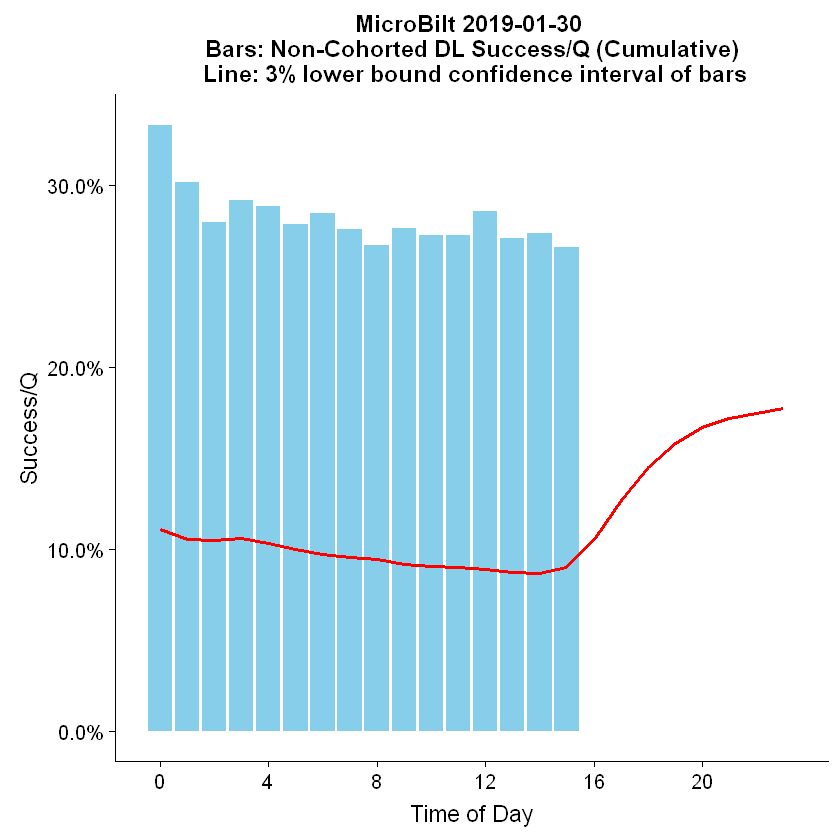

In [44]:
start = Sys.time()

getBootstrapPlot(
    df.bi = smoothLowerBound(
        ci.information = getBootstrapInterval(
            data = getDf(
                date.string = Sys.Date(), 
                ibv.provider = 'MicroBilt'
            ),
            cumulative = TRUE,
            B = 5000,
            alpha = 0.03
        ),
        iterations = 2
    ),
    title = 'MicroBilt'
)

end = Sys.time()
end - start

In [ ]:
start = Sys.time()

getBootstrapPlot(
    df.bi = smoothLowerBound(
        ci.information = getBootstrapInterval(
            data = getDf(
                date.string = Sys.Date(), 
                ibv.provider = 'DecisionLogic'
            ),
            cumulative = TRUE,
            B = 5000,
            alpha = 0.03
        ),
        iterations = 2
    ),
    title = 'DecisionLogic'
)

end = Sys.time()
end - start

In [ ]:
start = Sys.time()

getBootstrapPlot(
    df.bi = smoothLowerBound(
        ci.information = getBootstrapInterval(
            data = getDf(
                date.string = Sys.Date(), 
                numerator = 'bankverified',
                denominator = 'qualified'
            ),
            cumulative = TRUE,
            B = 5000,
            alpha = 0.03
        ),
        iterations = 2
    ),
    title = 'BV/Q'
)

end = Sys.time()
end - start

In [ ]:
start = Sys.time()

getBootstrapPlot(
    df.bi = smoothLowerBound(
        ci.information = getBootstrapInterval(
            data = getDf(
                date.string = Sys.Date(), 
                numerator = 'passscorecardratecard',
                denominator = 'bankverified'
            ),
            cumulative = TRUE,
            B = 5000,
            alpha = 0.03
        ),
        iterations = 2
    ),
    title = 'SC/BV'
)

end = Sys.time()
end - start

In [ ]:
start = Sys.time()

getBootstrapPlot(
    df.bi = smoothLowerBound(
        ci.information = getBootstrapInterval(
            data = getDf(
                date.string = Sys.Date(), 
                numerator = 'contractsigned',
                denominator = 'passscorecardratecard'
            ),
            cumulative = TRUE,
            B = 5000,
            alpha = 0.03
        ),
        iterations = 2
    ),
    title = 'CS/SC'
)

end = Sys.time()
end - start

In [ ]:
start = Sys.time()

getBootstrapPlot(
    df.bi = smoothLowerBound(
        ci.information = getBootstrapInterval(
            data = getDf(
                date.string = Sys.Date(), 
                numerator = 'cs_decisioned',
                denominator = 'contractsigned'
            ),
            cumulative = TRUE,
            B = 5000,
            alpha = 0.03
        ),
        iterations = 2
    ),
    title = 'Decisioned/CS'
)

end = Sys.time()
end - start

In [ ]:
start = Sys.time()

getBootstrapPlot(
    df.bi = smoothLowerBound(
        ci.information = getBootstrapInterval(
            data = getDf(
                date.string = Sys.Date(), 
                numerator = 'funded',
                denominator = 'cs_decisioned'
            ),
            cumulative = TRUE,
            B = 5000,
            alpha = 0.03
        ),
        iterations = 2
    ),
    title = 'F/Decisioned'
)

end = Sys.time()
end - start

In [ ]:
start = Sys.time()

getBootstrapPlot(
    df.bi = smoothLowerBound(
        ci.information = getBootstrapInterval(
            data = getDf(
                date.string = Sys.Date(), 
                numerator = 'funded',
                denominator = 'qualified'
            ),
            cumulative = TRUE,
            B = 5000,
            alpha = 0.03
        ),
        iterations = 2
    ),
    title = 'Funding Rate'
)

end = Sys.time()
end - start

In [ ]:
df.bi = getBootstrapInterval(
    data = df,
    B = 5000,
    alpha = 0.03
)$ci.information

ggplot() +
geom_line(
    data = df.bi,
    mapping = aes(
        x = hour.session,
        y = r.session
    ),
    color = 'skyblue',
    size = 3
) +
geom_line(
    data = df.bi,
    mapping = aes(
        x = hour.session,
        y = ci.lower
    ),
    color = 'red',
    size = 1,
    linetype = 6
) +
geom_point(
    data = makeCumulative(data = df),
    mapping = aes(
        x = hourofday,
        y = dl.hist.cum/q.hist.cum
    ),
    color = 'black',
    size = 0.8,
    alpha = 0.1
) +
# geom_ribbon(
#     data = makeCumulative(data = df) %>%
#         group_by(
#             hourofday
#         ) %>%
#         summarize(
#             ribbon.lower = min(dl.hist.cum/q.hist.cum),
#             ribbon.upper = max(dl.hist.cum/q.hist.cum)
#         ), 
#     mapping = aes(
#         x = hourofday,
#         ymin = ribbon.lower,
#         ymax = ribbon.upper
#     ),
#     color = 'black',
#     size = 0.8,
#     alpha = 0.1
# ) +
scale_y_continuous(
    labels = scales::percent,
#     limits = c(
#         min(dl.hist.cum/q.hist.cum),
#         max(dl.hist.cum/q.hist.cum),
#     ) 
    limits = c(0.20,0.70)
) 


# + 
# labs(
#     x ="Time of Day", 
#     y = "Success/Q", 
#     title = paste(
#         "DL ", getSessionInfo(data = df)$date,
#         "\n", "Bars: Non-Cohorted DL Success/Q (Cumulative)", 
#         "\n", "Line: 5% lower bound confidence interval of bars")
# ) + 
# geom_line(
#     aes(
#         x = hour.session, 
#         y = ci.lower
#     ), 
#     color = 'red', 
#     size=1
# ) + 
# # geom_line(
# #     aes(
# #         x = hour.session, 
# #         y = ci.upper
# #     ), 
# #     color = 'blue', 
# #     size=1
# # ) + 
# scale_x_continuous(
#     breaks = seq(0,23,4)
# )# + geom_line(aes(x=hourofday, y=upper), color='springgreen4', size=1) + scale_y_continuous(labels=scales::percent) + scale_x_continuous(breaks=seq(0,23,4))
